## Import modules

In [18]:
import pandas as pd
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import preprocessor as p
import time

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from helpers.text_preprocessor import clean_tweets
from helpers.model_pipeline import *

## Import data

In [5]:
final_data = pd.read_csv('../data/processed/data_final.csv', usecols=['filtered_tweet', 'is_depression'])

In [6]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329221 entries, 0 to 329220
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   filtered_tweet  329221 non-null  object
 1   is_depression   329221 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.0+ MB


In [7]:
#Check for duplicates before saving
final_data.drop_duplicates(inplace= True)
final_data.shape

(329221, 2)

In [8]:
final_data['is_depression'].value_counts()

is_depression
0    168930
1    160291
Name: count, dtype: int64

## Data analysis

We need to analyze the frequencies of the words in the two classes and visualize them to discover which words affect the depression label.

In [9]:
depressed_data = final_data[final_data['is_depression'] == 1] 
not_depressed_data = final_data[final_data['is_depression'] == 0]

In [ ]:
# get all words in the depressed tweets
depressed_text = " ".join(i for i in depressed_data.filtered_tweet ) 

# get all words in the non depressed tweets
not_depressed_text = " ".join(i for i in not_depressed_data.filtered_tweet) 

We use the word cloud graph to show the most frequent words in each class

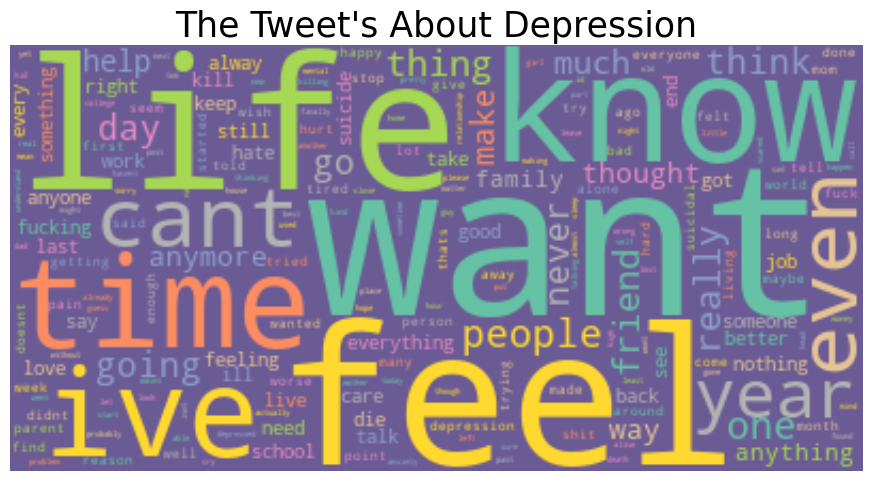

In [11]:
wordcloud = WordCloud(
    background_color="#6B5B95",
    colormap="Set2",
    collocations=False).generate(depressed_text)

plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("The Tweet's About Depression",size = 25)
plt.show()

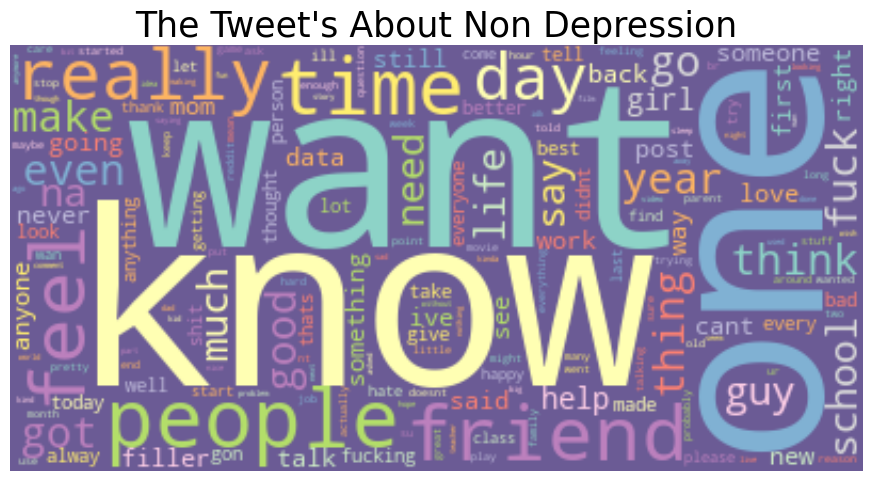

In [12]:
wordcloud = WordCloud(
    background_color="#6B5B95",
    colormap="Set3",
    collocations=False).generate(not_depressed_text)

plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("The Tweet's About Non Depression",size = 25)
plt.show()

We want to show the frequencies as numerical counts

In [13]:
# count each word frequency in the depressed tweets
depressed_text_counts = WordCloud().process_text(depressed_text) 

In [14]:
depressed_text_counts = pd.DataFrame.from_dict(depressed_text_counts.items())
depressed_text_counts.columns = ['word','count']
depressed_text_counts

,word,count
0,today,6313
1,taking,1313
2,moment,4886
3,reflect,202
4,far,2532
...,...,...
309954,nftgiveaways mentalhealth,2
309955,mentalhealth mushroomhead,2
309956,xjixiuinun divya,1
309957,divya gandotra,1


In [15]:
depressed_text_counts.sort_values(by = 'count',ascending = False).head(15)

,word,count
187316,want die,15093
49,think,13549
62,one,12557
351,work,11529
35,still,11426
1077,well,11211
464,better,10627
185095,year old,10367
185386,gon na,10151
185634,every day,9871


## Split data

In [16]:
X = final_data['filtered_tweet']
y = final_data["is_depression"].values

In [17]:
x_train,x_test,y_train,y_test=train_test_split(X, 
                                               y, 
                                               test_size=0.05, 
                                               random_state=42, 
                                               shuffle=True)

## Models

## Multinomial Naive Bayes

### Search optimal hyperparameters

In [20]:
parameters = {'clf__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]}
mnb_best = Pipeline([
    ('vect', CountVectorizer(max_features=30000)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(fit_prior = False))])
clf = GridSearchCV(mnb_best, parameters, n_jobs=-1)
clf.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=30000)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultinomialNB(fit_prior=False))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100,
                                        1000]})

In [21]:
Model_best = clf.best_estimator_
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

Best parameter (CV score=0.862):
{'clf__alpha': 0.1}


### Train

In [23]:
mnb,mnb_run_time = pipeline_model(
    MultinomialNB(
        alpha = 0.1, 
        fit_prior = False),
        x_train,
        y_train)

Training time (s): 33.24860


In [24]:
model_train_results(mnb, x_train, y_train)

Accuracy score for train data: 0.8692187914656333


### Test and evaluation

Accuracy score for test data: 0.8620459239460576
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      8388
           1       0.84      0.89      0.86      8074

    accuracy                           0.86     16462
   macro avg       0.86      0.86      0.86     16462
weighted avg       0.86      0.86      0.86     16462

Sensitivity: 0.8948476591528363
Specificity: 0.8304721030042919


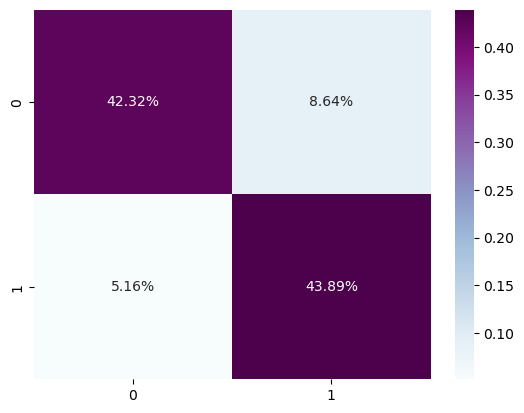

In [25]:
model_test_results(mnb, x_test, y_test)

In [ ]:
cross_validation_score(mnb, x_train, y_train)

Mean cross validation score  0.8610646645960122


ROC AUC score for the model: 0.9350


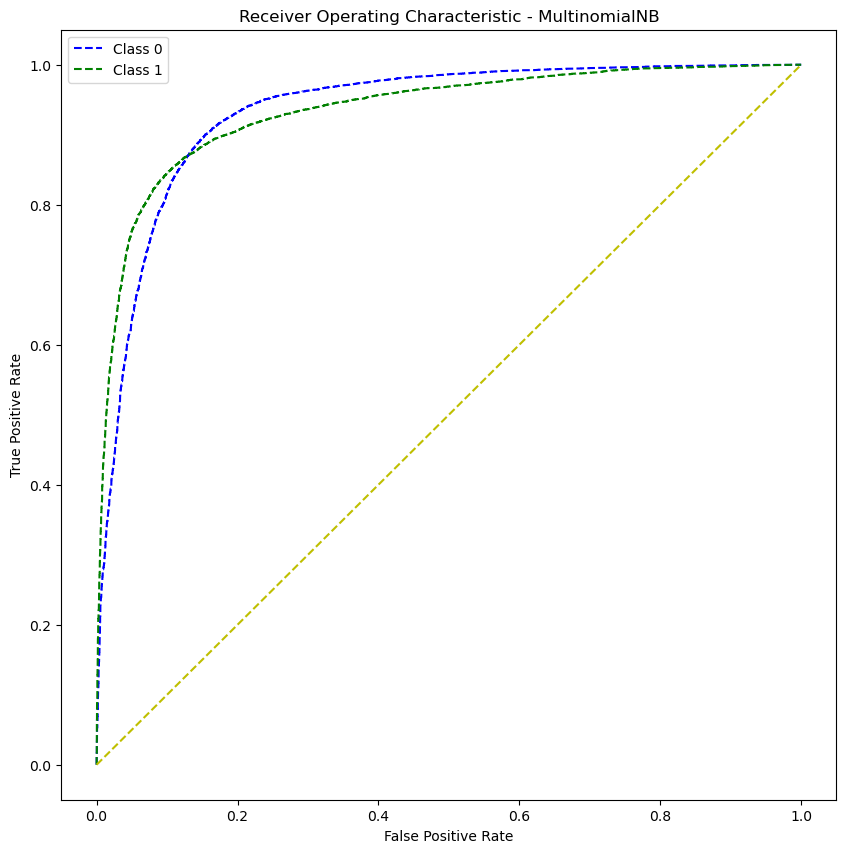

In [26]:
auc_roc(mnb, x_test, y_test, "MultinomialNB")

## Stochastic gradient descent

### Search optimal hyperparameters

In [15]:
parameters = {'clf__loss':('log', 'modified_huber','hinge'), 'clf__penalty':['elasticnet','l2'],
'clf__max_iter':[25,50,75],'clf__alpha': [.0001]}
SGDClf = Pipeline([
    ('vect', CountVectorizer(max_features=30000)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())])
clf = GridSearchCV(SGDClf, parameters)
clf.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=30000)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', SGDClassifier())]),
             param_grid={'clf__alpha': [0.0001],
                         'clf__loss': ('log', 'modified_huber', 'hinge'),
                         'clf__max_iter': [25, 50, 75],
                         'clf__penalty': ['elasticnet', 'l2']})

In [16]:
Model_best = clf.best_estimator_
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

Best parameter (CV score=0.888):
{'clf__alpha': 0.0001, 'clf__loss': 'modified_huber', 'clf__max_iter': 50, 'clf__penalty': 'l2'}


### Train model

In [27]:
SGDClf, SGDClf_run_time = pipeline_model(
    SGDClassifier(
        loss= 'modified_huber', 
        penalty='l2',
        alpha=.0001, 
        random_state=42,
        max_iter=60, 
        tol=None,
        learning_rate ='adaptive',
        eta0 = 0.01,
        fit_intercept= False)
        , x_train, y_train)

Training time (s): 55.18649


In [28]:
model_train_results(SGDClf, x_train, y_train)

Accuracy score for train data: 0.8875428045236108


### Test and evaluation

Accuracy score for test data: 0.8768679382821042
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      8388
           1       0.88      0.87      0.87      8074

    accuracy                           0.88     16462
   macro avg       0.88      0.88      0.88     16462
weighted avg       0.88      0.88      0.88     16462

Sensitivity: 0.8734208570720833
Specificity: 0.8801859799713877


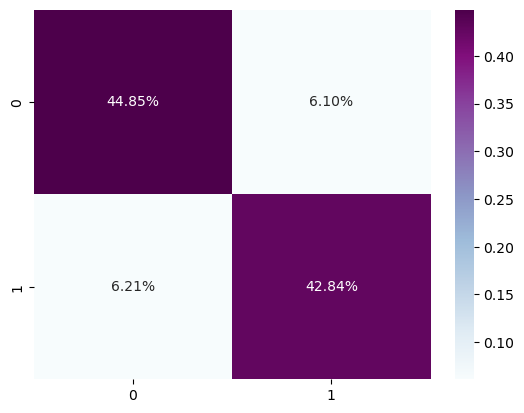

In [29]:
model_test_results(SGDClf, x_test, y_test)

In [ ]:
cross_validation_score(SGDClf, x_train, y_train)

Mean cross validation score  0.887395007863122


ROC AUC score for the model: 0.9425


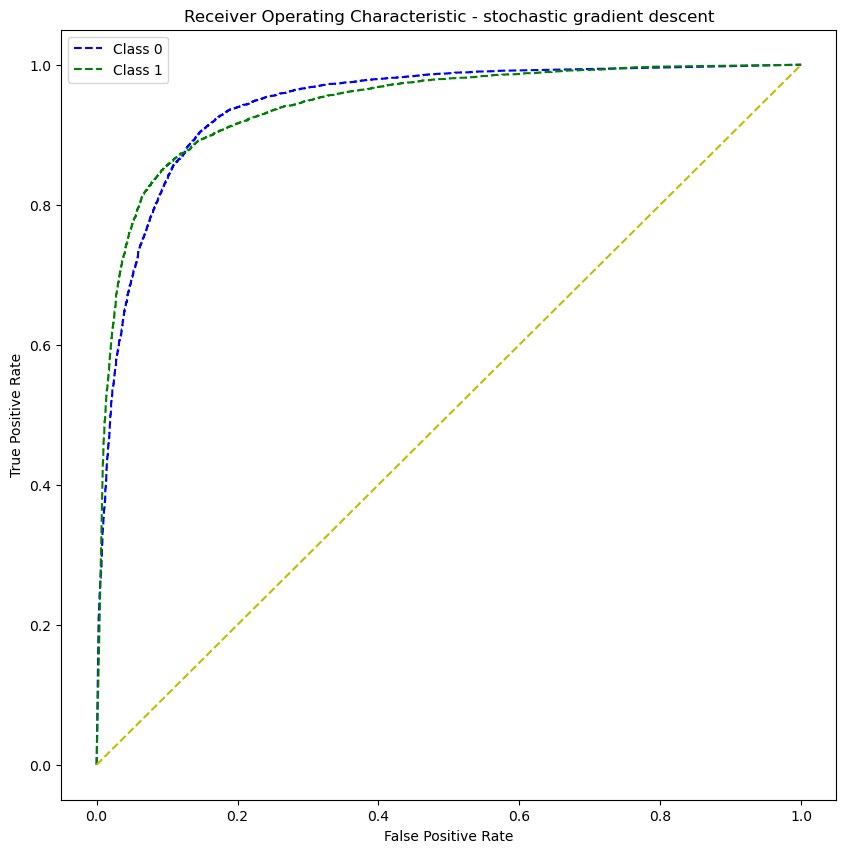

In [30]:
auc_roc(SGDClf, x_test, y_test, "stochastic gradient descent")

## DecisionTreeClassifier

### Search optimal hyperparameters

In [ ]:
parameters = {'clf__criterion':('gini', 'entropy'), 'clf__max_depth' : [20,30,40],
'clf__min_samples_split': [50,75,100]}
DTClf = Pipeline([
    ('vect', CountVectorizer(max_features=5000)),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier(random_state=42))])
clf = GridSearchCV(DTClf, parameters)
clf.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=5000)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'clf__criterion': ('gini', 'entropy'),
                         'clf__max_depth': [20, 30, 40],
                         'clf__min_samples_split': [50, 75, 100]})

In [ ]:
Model_best = clf.best_estimator_
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

Best parameter (CV score=0.816):
{'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 100}


### Train model

In [ ]:
DTClf,DTClf_run_time = pipeline_model(
    DecisionTreeClassifier(
        criterion ='gini',
        max_depth= 20, 
        min_samples_split= 100,
        random_state=42),
        x_train, 
        y_train)

Training time (s):  161.85913


In [ ]:
model_train_results(DTClf, x_train, y_train)

Accuracy score for train data 0.8484222575354029


### Test and evaluation

Accuracy score for test data 0.8267419962335216
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      8423
           1       0.88      0.75      0.81      8038

    accuracy                           0.83     16461
   macro avg       0.83      0.83      0.83     16461
weighted avg       0.83      0.83      0.83     16461

Senstivity: 0.7510574769843245
Specificity: 0.898967113854921
Confusion matrix:


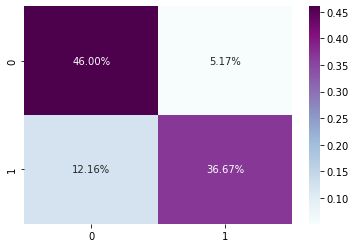

In [ ]:
model_test_results(DTClf, x_test, y_test)

roc_auc_score for the model: 0.8687664054012468


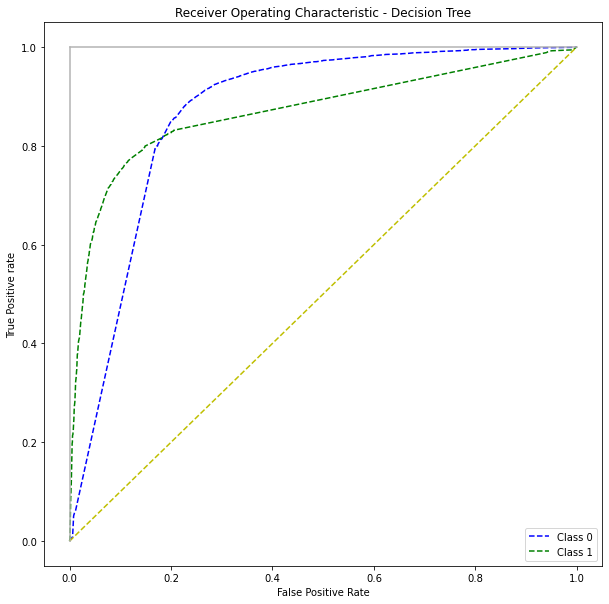

In [ ]:
auc_roc(DTClf, x_test, y_test, "Decision Tree")

## RandomForestClassifier

### Search optimal hyperparameters

In [27]:
param_grid = { 
    'clf__n_estimators': [200, 500],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth' : [20,30],
    'clf__criterion' :['gini', 'entropy'],
    'clf__min_samples_split': [50,75]
}
RF = Pipeline([
    ('vect', CountVectorizer(max_features=5000)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state=42))])
CV_rfc = GridSearchCV(estimator=RF, param_grid=param_grid,n_jobs = -1)
CV_rfc.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=5000)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [20, 30],
                         'clf__max_features': ['sqrt', 'log2'],
                         'clf__min_samples_split': [50, 75],
                         'clf__n_estimators': [200, 500]})

In [ ]:
Model_best = clf.best_estimator_
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

### Train model

In [ ]:
RFClf,RFClf_run_time = pipeline_model(
    RandomForestClassifier(
        n_estimators = 100,
        criterion ='entropy',
        max_depth= 30, 
        min_samples_split= 50,
        max_features='sqrt',
        random_state=42),
        x_train,
        y_train)

Training time (s):  243.82706


In [ ]:
model_train_results(RFClf, x_train, y_train)

Accuracy score for train data 0.8373113951086626


### Test and evaluation

Accuracy score for test data 0.818905291294575
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      8423
           1       0.88      0.73      0.80      8038

    accuracy                           0.82     16461
   macro avg       0.83      0.82      0.82     16461
weighted avg       0.83      0.82      0.82     16461

Senstivity: 0.7289126648420005
Specificity: 0.9047845185800784
Confusion matrix:


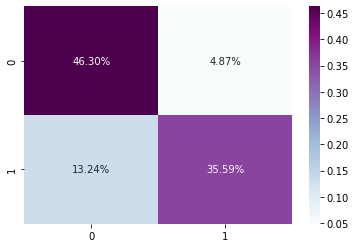

In [ ]:
model_test_results(RFClf, x_test, y_test)

roc_auc_score for the model: 0.8865569079343734


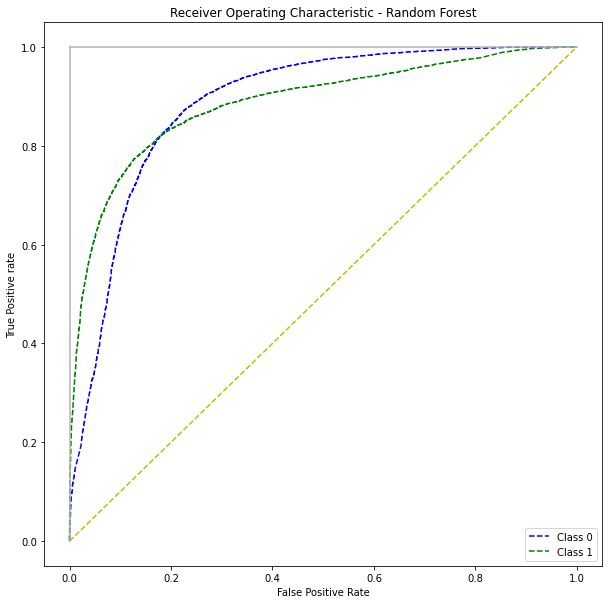

In [ ]:
auc_roc(RFClf, x_test, y_test, "Random Forest")

## KNeighborsClassifier

### Search optimal hyperparameters

In [29]:
KNN = Pipeline([
    ('vect', CountVectorizer(max_features=5000)),
    ('tfidf', TfidfTransformer()),
    ('clf',KNeighborsClassifier())])

param_grid = {'clf__n_neighbors' : [3,5,9,13,15]}
CV_KNN = GridSearchCV(KNN, param_grid)
CV_KNN.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=5000)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': [3, 5, 9, 13, 15]})

In [30]:
Model_best = CV_KNN.best_estimator_
print("Best parameter (CV score=%0.3f):" % CV_KNN.best_score_)
print(CV_KNN.best_params_)

Best parameter (CV score=0.562):
{'clf__n_neighbors': 5}


### Train model

In [ ]:
knn,knn_run_time = pipeline_model(
    KNeighborsClassifier(
        n_neighbors=5),
        x_train, 
        y_train
        )

Training time (s):  19.36389


In [ ]:
model_train_results(knn, x_train, y_train)

c:\Users\ZIAD\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy score for train data 0.6049520874033195


### Test model

c:\Users\ZIAD\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy score for test data 0.7412672377133831
              precision    recall  f1-score   support

           0       0.71      0.83      0.77      8423
           1       0.79      0.65      0.71      8038

    accuracy                           0.74     16461
   macro avg       0.75      0.74      0.74     16461
weighted avg       0.75      0.74      0.74     16461

Senstivity: 0.645434187608858
Specificity: 0.8327199335153745
Confusion matrix:


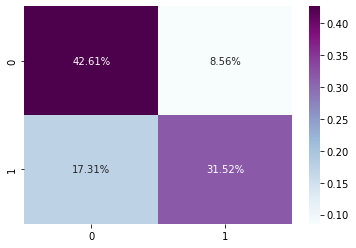

In [ ]:
model_test_results(knn, x_test, y_test)

roc_auc_score for the model: 0.804841212361903


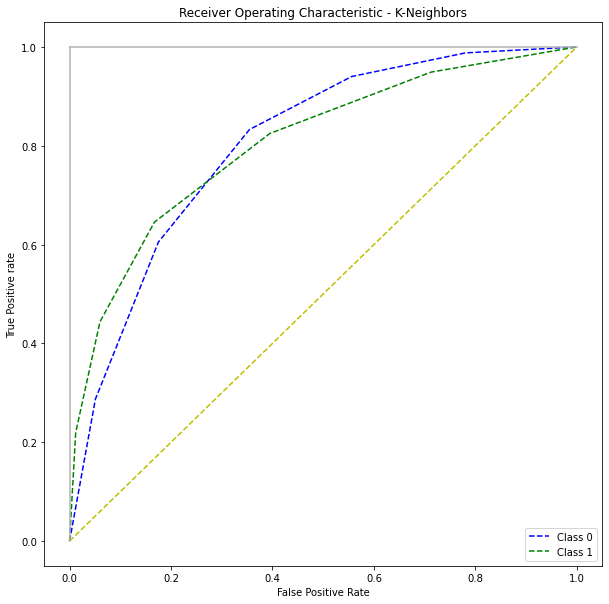

In [ ]:
auc_roc(knn, x_test, y_test, "K-Neighbors")

## Save the models

In [32]:
import joblib 
joblib.dump(mnb,'../models/mnb_v2.pkl')

['../models/mnb_v2.pkl']

In [34]:
joblib.dump(SGDClf,'../models/sgd_v2.pkl')

['../models/sgd_v2.pkl']

## Conclusion

We can see that MNB and SGD have a higher performance and lower run time we will use them for deployment.